In [169]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
sys.path.append("../data/embeddings")
sys.path.append("../data/biasbios")
sys.path.append("../data/embeddings/biasbios")
import classifier
import svm_classifier
import debias
import gensim
import codecs
import json
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import numpy as np
import random
import sklearn
from sklearn import model_selection
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import DictVectorizer
from pytorch_transformers import BertTokenizer, BertModel, BertForMaskedLM

import scipy
from scipy import linalg
from scipy import sparse
from scipy.stats.stats import pearsonr
import tqdm
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier, SGDRegressor, Perceptron, LogisticRegression
from sklearn.utils import shuffle

%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000

import warnings
warnings.filterwarnings("ignore")

import pickle
from collections import defaultdict, Counter
from typing import List, Dict

import torch
from torch import utils

import pytorch_lightning as pl
from pytorch_lightning import Trainer
import copy
import pandas as pd
from gensim.models import FastText
import time
from gensim.scripts.glove2word2vec import glove2word2vec

STOPWORDS = set(["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:


def load_dataset(path):
    
    with open(path, "rb") as f:
        
        data = pickle.load(f)
    return data

def load_dictionary(path):
    
    with open(path, "r", encoding = "utf-8") as f:
        
        lines = f.readlines()
        
    k2v, v2k = {}, {}
    for line in lines:
        
        k,v = line.strip().split("\t")
        v = int(v)
        k2v[k] = v
        v2k[v] = k
    
    return k2v, v2k
    
def count_profs_and_gender(data: List[dict]):
    
    counter = defaultdict(Counter)
    for entry in data:
        gender, prof = entry["g"], entry["p"]
        counter[prof][gender] += 1
        
    return counter


In [ ]:
train = load_dataset("../data/biasbios/hila/train.pickle")
dev = load_dataset("../data/biasbios/hila/dev.pickle")
test = load_dataset("../data/biasbios/hila/test.pickle")

#w2i, i2w = load_dictionary("../data/biasbios/word2index.txt")
p2i, i2p = load_dictionary("../data/biasbios/profession2index.txt")
g2i, i2g = load_dictionary("../data/biasbios/gender2index.txt")
counter = count_profs_and_gender(train+dev+test)

In [5]:
p2i

{'accountant': 0,
 'architect': 1,
 'attorney': 2,
 'chiropractor': 3,
 'comedian': 4,
 'composer': 5,
 'dentist': 6,
 'dietitian': 7,
 'dj': 8,
 'filmmaker': 9,
 'interior_designer': 10,
 'journalist': 11,
 'model': 12,
 'nurse': 13,
 'painter': 14,
 'paralegal': 15,
 'pastor': 16,
 'personal_trainer': 17,
 'photographer': 18,
 'physician': 19,
 'poet': 20,
 'professor': 21,
 'psychologist': 22,
 'rapper': 23,
 'software_engineer': 24,
 'surgeon': 25,
 'teacher': 26,
 'yoga_teacher': 27}

In [6]:
counter = count_profs_and_gender(train+dev+test)
f,m = 0., 0.
prof2fem = dict()

for k, values in counter.items():
    f += values['f']
    m += values['m']
    prof2fem[k] = values['f']/(values['f'] + values['m'])

print(f / (f + m))
print(prof2fem)

0.46286566875856267
{'teacher': 0.603111879476414, 'professor': 0.45118956904580476, 'attorney': 0.38316925813475633, 'surgeon': 0.14857228961048746, 'photographer': 0.35721920736720936, 'painter': 0.4579886246122027, 'psychologist': 0.6223011751844766, 'filmmaker': 0.3295762590954487, 'physician': 0.507688318423441, 'interior_designer': 0.8086124401913876, 'architect': 0.23712053792148718, 'dietitian': 0.9273504273504274, 'pastor': 0.24052132701421802, 'rapper': 0.09665955934612651, 'journalist': 0.49488721804511276, 'dentist': 0.35589474411216243, 'accountant': 0.36818825194621374, 'poet': 0.49080017115960634, 'model': 0.8283124500133298, 'nurse': 0.9085446207369142, 'chiropractor': 0.26558891454965355, 'yoga_teacher': 0.8454600120264583, 'software_engineer': 0.1576889661164205, 'paralegal': 0.8483305036785512, 'composer': 0.16392857142857142, 'personal_trainer': 0.45670391061452514, 'comedian': 0.21150410861021793, 'dj': 0.1420875420875421}


In [7]:
print(p2i)

{'accountant': 0, 'architect': 1, 'attorney': 2, 'chiropractor': 3, 'comedian': 4, 'composer': 5, 'dentist': 6, 'dietitian': 7, 'dj': 8, 'filmmaker': 9, 'interior_designer': 10, 'journalist': 11, 'model': 12, 'nurse': 13, 'painter': 14, 'paralegal': 15, 'pastor': 16, 'personal_trainer': 17, 'photographer': 18, 'physician': 19, 'poet': 20, 'professor': 21, 'psychologist': 22, 'rapper': 23, 'software_engineer': 24, 'surgeon': 25, 'teacher': 26, 'yoga_teacher': 27}


### get input representatons 

In [8]:

def load_word_vectors(fname = "../data/embeddings/vecs.filtered.with_gendered.glove.txt"):
    
    model = KeyedVectors.load_word2vec_format(fname, binary=False)
    vecs = model.vectors
    words = list(model.vocab.keys())
    return model, vecs, words


def get_embeddings_based_dataset(data: List[dict], word2vec_model, p2i, filter_stopwords = False):
    
    X, Y = [], []
    unk, total = 0., 0.
    unknown = []
    
    for entry in tqdm.tqdm(data, total = len(data)):
        
        y = p2i[entry["p"]]
        words = entry["hard_text"].split(" ")
        if filter_stopwords:
            words = [w for w in words if w.lower() not in STOPWORDS]
            
        bagofwords = np.sum([word2vec_model[w] if w in word2vec_model else word2vec_model["unk"] for w in words], axis = 0)
        #print(bagofwords.shape)
        X.append(bagofwords)
        Y.append(y)
        total += len(words)
        
        unknown_entry = [w for w in words if w not in word2vec_model]
        unknown.extend(unknown_entry)
        unk += len(unknown_entry)
    
    X = np.array(X)
    Y = np.array(Y)
    print("% unknown: {}".format(unk/total))
    return X,Y,unknown

def get_BOW_based_dataset(data: List[dict], w2i):
    
    vectorizer = DictVectorizer(sparse = True)
    X, Y = [], []
    unk, total = 0., 0.
    data_dicts = []
    unknown = []
    
    for entry in tqdm.tqdm(data, total = len(data)):
        text, start, y = entry["text"], entry["start"], entry["p"]
        #text = text.lower()
        words = text[start + 1:].split(" ")
        entry_dict = {w:w2i[w] if w in w2i else w2i["<UNK>"] for w in words}
        data_dicts.append(entry_dict)
        Y.append(y)
        
        total += len(words)
        unknown_entry = [w for w in words if w not in w2i]
        unk += len([w for w in words if w not in w2i])
        unknown.extend(unknown_entry)
    
    print("% unknown: {}".format(unk/total))
    X = vectorizer.fit_transform(data_dicts)
    return X,Y, unknown
    
def get_bert_based_dataset(data: List[dict], p2i):
    
    tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
    model = BertModel.from_pretrained('bert-base-cased').cuda()
    model.eval()
    
    X, Y = [], []
    cls_lst = ['[CLS]']
    sep_lst = ['[SEP]']
    
    for entry in tqdm.tqdm(data, total = len(data)):
        text, y = entry["hard_text"], p2i[entry["p"]]
        #text = text.lower()            
        tokenized_text = cls_lst + tokenizer.tokenize(text)[:500] + sep_lst    
        indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
        tokens_tensor = torch.tensor([indexed_tokens]).cuda()
        with torch.no_grad():
              outputs = model(tokens_tensor)[0]
              out_np = outputs.detach().cpu().numpy()
              out_np = out_np.squeeze(0)
              BOW = out_np[-1][:] #np.sum(out_np, axis = 0)
              X.append(BOW)
              Y.append(y)
    
    X = np.array(X)
    Y = np.array(Y)
    
    return X,Y

In [9]:
#word2vec, vecs, words = load_word_vectors("../data/embeddings/wiki-news-300d-1M-subword.vec") #load_word2vec()
word2vec, vecs, words = load_word_vectors("../data/embeddings/crawl-300d-2M.vec")
#path = "../data/embeddings/crawl-300d-2M-subword.bin"
#word2vec = gensim.models.fasttext.load_facebook_vectors(path)
#word2vec.init_sims(replace = True)
#X_train, Y_train = get_BOW_based_dataset(train, w2i)
#X_devword2vec.init_sims(replace = True), Y_dev = get_BOW_based_dataset(dev, w2i) 


In [ ]:
#word2vec.init_sims(replace = True)

In [10]:
embeds =  True

if embeds:
    X_train, Y_train, unknown_train = get_embeddings_based_dataset(train, word2vec, p2i)
    X_dev, Y_dev, unknown_dev =  get_embeddings_based_dataset(dev, word2vec, p2i)
    X_test, Y_test, unknown_test =  get_embeddings_based_dataset(test, word2vec, p2i)
else:
    
    X_train, Y_train, unk = get_bert_based_dataset(train, p2i)
    X_dev, Y_dev, unk =  get_bert_based_dataset(dev, p2i)
    X_test, Y_test, unk =  get_bert_based_dataset(test, p2i)
#X_train, Y_train = get_bert_based_dataset(train)

  2%|▏         | 629/39369 [00:00<00:06, 6283.58it/s]

% unknown: 0.010376065231423514


  1%|          | 579/98344 [00:00<00:16, 5786.49it/s]

% unknown: 0.011207613846339256


100%|██████████| 98344/98344 [00:17<00:00, 5656.24it/s]


% unknown: 0.01103116868957796


In [ ]:
mean_x = np.mean(X_train, axis = 0, keepdims = True)
std_x = np.std(X_train, axis = 0, keepdims = True)

#X_train = (X_train-mean_x)/std_x
#X_dev = (X_dev-mean_x)/std_x
#X_test = (X_test-mean_x)/std_x

print(np.linalg.norm(X_dev[0]))
print("len train: {}; len dev: {}; len test: {}".format(len(train), len(dev), len(test)))

In [ ]:
#X_test = (X_test-mean_x)/std_x


In [ ]:
d = load_dataset("../data/biasbios/BIOS.OLD.pkl")
d2 = load_dataset("../data/biasbios/BIOS.pkl")
len(d)

In [170]:
#clf = LinearSVC(max_iter = 10) #LogisticRegression()
#clf = SGDClassifier(warm_start = True, loss = 'log', n_jobs = 64, max_iter = 250, random_state = 0)

if MLP:
    clf = MLPClassifier(activation = "identity", hidden_layer_sizes = (100,), max_iter = 15)
else:
    clf = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "sag", multi_class = 'multinomial', fit_intercept = True,
                         verbose = 10, max_iter = 3, n_jobs = 64, random_state = 1)
#clf = SGDClassifier(loss= 'log', max_iter= 3000, fit_intercept= True, class_weight= None, n_jobs= 100)
#clf = LinearSVC(max_iter = 50) #LogisticRegression()

start = time.time()
idx = np.random.rand(X_train.shape[0]) < 1.0
clf.fit(X_train[idx], Y_train[idx])
print("time: {}".format(time.time() - start))
print(clf.score(X_dev, Y_dev))
print(clf.score(X_test, Y_test))
clf_original = copy.deepcopy(clf)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 24 seconds
time: 24.36724019050598
0.7666946074322436


[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:   23.8s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   23.8s finished


0.772817863824941


In [171]:
print(clf.score(X_test, Y_test))


0.772817863824941


#### Confusion Matrix

In [ ]:
"""
y_hat = clf.predict(X_dev)
cm = sklearn.metrics.confusion_matrix(Y_dev,y_hat)
labels = [i2p[i] for i in range(len(i2p))]
"""

In [ ]:

"""
df_cm = pd.DataFrame(cm, index = labels, columns = labels)
#plt.figure(figsize = (10,7))
sn.set(font_scale=0.3)#for label size
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.savefig("confusion.png", dpi = 600)
plt.show()
 """
#clf = copy.deepcopy(clf_original)

#MLP = True
#clf = copy.deepcopy(clf_original)

### perform debiasing

In [184]:
def get_projection_matrix(num_clfs, X_train, Y_train, X_dev, Y_dev, Y_train_task, Y_dev_task, dim, all_data_prob, by_class = False):

    is_autoregressive = True
    min_acc = 0.
    noise = False
    dim = 300
    n = num_clfs
    random_subset = 1
    start = time.time()
    TYPE= "svm"
    penalty = "l2"
    
    if MLP:
        x_train_gender = np.matmul(X_train, clf.coefs_[0]) + clf.intercepts_[0]
        x_dev_gender = np.matmul(X_dev, clf.coefs_[0]) + clf.intercepts_[0]
    else:
        x_train_gender = X_train.copy()
        x_dev_gender = X_dev.copy()
        
    
    if TYPE == "sgd":
        print("using sgd")
        gender_clf = SGDClassifier
        params = {'penalty': penalty, 'loss': 'hinge', 'max_iter': 3000, 'fit_intercept': False, 'class_weight': None, 'n_jobs': 100}
    elif TYPE == "svm":
        gender_clf = LinearSVC
        params = {'max_iter': 30000, 'fit_intercept': False, 'class_weight': None, "dual": False}
    elif TYPE == "perceptron":
        gender_clf = Perceptron
        params = {'max_iter': 1000, 'fit_intercept': True, 'class_weight': None}
        
    P = debias.get_debiasing_projection(gender_clf, params, n, dim, is_autoregressive, min_acc,
                                              x_train_gender, Y_train, x_dev_gender, Y_dev, noise=noise, random_subset = random_subset,
                                       Y_train_main=Y_train_task, Y_dev_main=Y_dev_task, 
                                        by_class = by_class, all_data_prob = all_data_prob, k = 0, all_data_iterations = 0)
    print("time: {}".format(time.time() - start))
    return P

prof2P = dict()
P_all = np.eye(300)
"""
for i,prof in enumerate(p2i.keys()):
    print("ITERATION {} OUT OF {}; PROFESSION: {}".format(i, len(p2i), prof))
    num_clfs = 7
    Y_dev_gender = np.array([g2i[d["g"]] for d in dev])
    Y_train_gender = np.array([g2i[d["g"]] for d in train])
    rel_idx_train = Y_train == p2i[prof]
    rel_idx_dev = Y_dev == p2i[prof]
    

    P = get_projection_matrix(num_clfs, X_train[rel_idx_train].dot(P_all), Y_train_gender[rel_idx_train], X_dev[rel_idx_dev].dot(P_all), Y_dev_gender[rel_idx_dev], Y_train, Y_dev, dim = 300, all_data_prob = 0.0,
                             by_class = False)
    prof2P[prof] = P
    P_all = P_all.dot(P)

""" 

num_clfs = 150
Y_dev_gender = np.array([g2i[d["g"]] for d in dev])
Y_train_gender = np.array([g2i[d["g"]] for d in train])
#idx = np.random.rand(X_train.shape[0]) < 1.
P = get_projection_matrix(num_clfs, X_train, Y_train_gender, X_dev, Y_dev_gender, Y_train, Y_dev, 300, 0.0, by_class= True)




  0%|          | 0/150 [00:00<?, ?it/s]

by class: True, all_data_iterations: 0, k: 0
Iteration 0, Accuracy: 0.9876806624501512




  1%|          | 1/150 [00:16<41:22, 16.66s/it]

Iteration 1, Accuracy: 0.9121621621621622




  1%|▏         | 2/150 [00:17<29:45, 12.06s/it]

Iteration 2, Accuracy: 0.9003831417624522




  2%|▏         | 3/150 [00:20<22:53,  9.34s/it]

Iteration 3, Accuracy: 0.848314606741573




  3%|▎         | 4/150 [00:22<17:08,  7.04s/it]

Iteration 4, Accuracy: 0.8241106719367589




  3%|▎         | 5/150 [00:24<13:15,  5.49s/it]

Iteration 5, Accuracy: 0.7755324959038776




  4%|▍         | 6/150 [00:27<11:00,  4.59s/it]

Iteration 6, Accuracy: 0.7094017094017094




  5%|▍         | 7/150 [00:28<08:44,  3.67s/it]

Iteration 7, Accuracy: 0.8020231213872833




  5%|▌         | 8/150 [00:29<07:00,  2.96s/it]

Iteration 8, Accuracy: 0.6944444444444444




  6%|▌         | 9/150 [00:31<05:46,  2.46s/it]

Iteration 9, Accuracy: 0.6714975845410628




  7%|▋         | 10/150 [00:33<05:30,  2.36s/it]

Iteration 10, Accuracy: 0.8028169014084507




  7%|▋         | 11/150 [00:34<04:45,  2.05s/it]

Iteration 11, Accuracy: 0.6860821581851625




  8%|▊         | 12/150 [00:37<05:37,  2.45s/it]

Iteration 12, Accuracy: 0.6826955638333898




  9%|▊         | 13/150 [00:47<10:43,  4.69s/it]

Iteration 13, Accuracy: 0.8671679197994987




  9%|▉         | 14/150 [00:49<08:25,  3.72s/it]

Iteration 14, Accuracy: 0.7528089887640449




 10%|█         | 15/150 [00:50<06:46,  3.01s/it]

Iteration 15, Accuracy: 0.8772590361445783




 11%|█         | 16/150 [00:52<05:54,  2.65s/it]

Iteration 16, Accuracy: 0.7380952380952381




 11%|█▏        | 17/150 [00:54<05:29,  2.48s/it]

Iteration 17, Accuracy: 0.7890173410404624




 12%|█▏        | 18/150 [00:56<04:51,  2.21s/it]

Iteration 18, Accuracy: 0.7362204724409449




 13%|█▎        | 19/150 [00:57<04:10,  1.92s/it]

Iteration 19, Accuracy: 0.6739486619333698




 13%|█▎        | 20/150 [00:59<04:11,  1.94s/it]

Iteration 20, Accuracy: 0.7875722543352601




 14%|█▍        | 21/150 [01:00<03:47,  1.77s/it]

Iteration 21, Accuracy: 0.6517101252963088




 15%|█▍        | 22/150 [01:08<07:42,  3.61s/it]

Iteration 22, Accuracy: 0.701067615658363




 15%|█▌        | 23/150 [01:10<06:18,  2.98s/it]

Iteration 23, Accuracy: 0.8455392809587217




 16%|█▌        | 24/150 [01:11<05:21,  2.55s/it]

Iteration 24, Accuracy: 0.7330960854092526




 17%|█▋        | 25/150 [01:12<04:25,  2.13s/it]

Iteration 25, Accuracy: 0.6352087114337568




 17%|█▋        | 26/150 [01:16<05:08,  2.49s/it]

Iteration 26, Accuracy: 0.637952176578786




 18%|█▊        | 27/150 [01:19<05:28,  2.67s/it]

Iteration 27, Accuracy: 0.6723102129983616




 19%|█▊        | 28/150 [01:21<04:56,  2.43s/it]

Iteration 28, Accuracy: 0.7535211267605634




 19%|█▉        | 29/150 [01:22<04:05,  2.03s/it]

Iteration 29, Accuracy: 0.6352705410821643




 20%|██        | 30/150 [01:24<04:22,  2.18s/it]

Iteration 30, Accuracy: 0.8998946259220232




 21%|██        | 31/150 [01:26<04:14,  2.14s/it]

Iteration 31, Accuracy: 0.6580353473078504




 21%|██▏       | 32/150 [01:29<04:29,  2.28s/it]

Iteration 32, Accuracy: 0.7732142857142857




 22%|██▏       | 33/150 [01:30<03:50,  1.97s/it]

Iteration 33, Accuracy: 0.617719190680564




 23%|██▎       | 34/150 [01:33<04:21,  2.26s/it]

Iteration 34, Accuracy: 0.6777717094483888




 23%|██▎       | 35/150 [01:35<04:23,  2.29s/it]

Iteration 35, Accuracy: 0.7921348314606742




 24%|██▍       | 36/150 [01:37<03:42,  1.95s/it]

Iteration 36, Accuracy: 0.6766794101583834




 25%|██▍       | 37/150 [01:39<03:37,  1.93s/it]

Iteration 37, Accuracy: 0.6137339055793991




 25%|██▌       | 38/150 [01:41<04:02,  2.17s/it]

Iteration 38, Accuracy: 0.7559523809523809




 26%|██▌       | 39/150 [01:43<03:34,  1.93s/it]

Iteration 39, Accuracy: 0.6580246913580247




 27%|██▋       | 40/150 [01:44<03:26,  1.88s/it]

Iteration 40, Accuracy: 0.7887323943661971




 27%|██▋       | 41/150 [01:46<03:04,  1.70s/it]

Iteration 41, Accuracy: 0.7394636015325671




 28%|██▊       | 42/150 [01:47<02:47,  1.55s/it]

Iteration 42, Accuracy: 0.6111111111111112




 29%|██▊       | 43/150 [01:48<02:35,  1.45s/it]

Iteration 43, Accuracy: 0.6333333333333333




 29%|██▉       | 44/150 [01:51<03:05,  1.75s/it]

Iteration 44, Accuracy: 0.6353276353276354




 30%|███       | 45/150 [01:52<02:53,  1.65s/it]

Iteration 45, Accuracy: 0.6274306455794659




 31%|███       | 46/150 [01:55<03:43,  2.15s/it]

Iteration 46, Accuracy: 0.8033707865168539




 31%|███▏      | 47/150 [01:57<03:16,  1.91s/it]

Iteration 47, Accuracy: 0.6149068322981367




 32%|███▏      | 48/150 [01:59<03:27,  2.03s/it]

Iteration 48, Accuracy: 0.7701149425287356




 33%|███▎      | 49/150 [02:00<03:03,  1.82s/it]

Iteration 49, Accuracy: 0.6501766784452296




 33%|███▎      | 50/150 [02:02<02:53,  1.73s/it]

Iteration 50, Accuracy: 0.5968992248062015




 34%|███▍      | 51/150 [02:03<02:48,  1.70s/it]

Iteration 51, Accuracy: 0.6297832712495767




 35%|███▍      | 52/150 [02:11<05:43,  3.51s/it]

Iteration 52, Accuracy: 0.9197994987468672




 35%|███▌      | 53/150 [02:12<04:37,  2.86s/it]

Iteration 53, Accuracy: 0.5891783567134269




 36%|███▌      | 54/150 [02:15<04:16,  2.67s/it]

Iteration 54, Accuracy: 0.588021778584392




 37%|███▋      | 55/150 [02:18<04:28,  2.83s/it]

Iteration 55, Accuracy: 0.8017857142857143




 37%|███▋      | 56/150 [02:19<03:47,  2.42s/it]

Iteration 56, Accuracy: 0.9298245614035088




 38%|███▊      | 57/150 [02:21<03:14,  2.09s/it]

Iteration 57, Accuracy: 0.6014714898835071




 39%|███▊      | 58/150 [02:24<03:40,  2.40s/it]

Iteration 58, Accuracy: 0.7547892720306514




 39%|███▉      | 59/150 [02:26<03:19,  2.19s/it]

Iteration 59, Accuracy: 0.7789017341040463




 40%|████      | 60/150 [02:27<02:59,  1.99s/it]

Iteration 60, Accuracy: 0.7259786476868327




 41%|████      | 61/150 [02:29<02:42,  1.83s/it]

Iteration 61, Accuracy: 0.6266149870801033




 41%|████▏     | 62/150 [02:30<02:39,  1.81s/it]

Iteration 62, Accuracy: 0.6524216524216524




 42%|████▏     | 63/150 [02:32<02:25,  1.67s/it]

Iteration 63, Accuracy: 0.6164917033525229




 43%|████▎     | 64/150 [02:40<05:29,  3.83s/it]

Iteration 64, Accuracy: 0.6132346896835182




 43%|████▎     | 65/150 [02:43<04:40,  3.30s/it]

Iteration 65, Accuracy: 0.7432950191570882




 44%|████▍     | 66/150 [02:44<03:48,  2.72s/it]

Iteration 66, Accuracy: 0.6875




 45%|████▍     | 67/150 [02:45<03:16,  2.37s/it]

Iteration 67, Accuracy: 0.595691382765531




 45%|████▌     | 68/150 [02:48<03:11,  2.33s/it]

Iteration 68, Accuracy: 0.8028169014084507




 46%|████▌     | 69/150 [02:49<02:39,  1.97s/it]

Iteration 69, Accuracy: 0.675587110868378




 47%|████▋     | 70/150 [02:51<02:50,  2.13s/it]

Iteration 70, Accuracy: 0.6378091872791519




 47%|████▋     | 71/150 [02:53<02:40,  2.03s/it]

Iteration 71, Accuracy: 0.6657564172583288




 48%|████▊     | 72/150 [02:55<02:39,  2.04s/it]

Iteration 72, Accuracy: 0.6107660455486542




 49%|████▊     | 73/150 [02:57<02:39,  2.07s/it]

Iteration 73, Accuracy: 0.6082621082621082




 49%|████▉     | 74/150 [02:59<02:25,  1.92s/it]

Iteration 74, Accuracy: 0.8035714285714286




 50%|█████     | 75/150 [03:00<02:08,  1.72s/it]

Iteration 75, Accuracy: 0.6002370470707755




 51%|█████     | 76/150 [03:07<04:06,  3.34s/it]

Iteration 76, Accuracy: 0.6025482942868886




 51%|█████▏    | 77/150 [03:09<03:39,  3.00s/it]

Iteration 77, Accuracy: 0.7153024911032029




 52%|█████▏    | 78/150 [03:11<03:05,  2.58s/it]

Iteration 78, Accuracy: 0.8322237017310253




 53%|█████▎    | 79/150 [03:12<02:37,  2.22s/it]

Iteration 79, Accuracy: 0.5977927651747394




 53%|█████▎    | 80/150 [03:15<02:43,  2.34s/it]

Iteration 80, Accuracy: 0.8098591549295775




 54%|█████▍    | 81/150 [03:17<02:22,  2.07s/it]

Iteration 81, Accuracy: 0.823943661971831




 55%|█████▍    | 82/150 [03:18<02:08,  1.89s/it]

Iteration 82, Accuracy: 0.823943661971831




 55%|█████▌    | 83/150 [03:19<01:55,  1.73s/it]

Iteration 83, Accuracy: 0.7183794466403162




 56%|█████▌    | 84/150 [03:21<01:48,  1.64s/it]

Iteration 84, Accuracy: 0.8202247191011236




 57%|█████▋    | 85/150 [03:23<01:50,  1.70s/it]

Iteration 85, Accuracy: 0.584045584045584




 57%|█████▋    | 86/150 [03:24<01:42,  1.60s/it]

Iteration 86, Accuracy: 0.625




 58%|█████▊    | 87/150 [03:26<01:39,  1.59s/it]

Iteration 87, Accuracy: 0.5782255333559092




 59%|█████▊    | 88/150 [03:33<03:23,  3.27s/it]

Iteration 88, Accuracy: 0.5480943738656987




 59%|█████▉    | 89/150 [03:36<03:16,  3.23s/it]

Iteration 89, Accuracy: 0.6302469135802469




 60%|██████    | 90/150 [03:38<02:51,  2.86s/it]

Iteration 90, Accuracy: 0.5640027091093803




 61%|██████    | 91/150 [03:45<04:13,  4.29s/it]

Iteration 91, Accuracy: 0.8154761904761905




 61%|██████▏   | 92/150 [03:47<03:19,  3.44s/it]

Iteration 92, Accuracy: 0.8787650602409639




 62%|██████▏   | 93/150 [03:49<02:48,  2.96s/it]

Iteration 93, Accuracy: 0.6519434628975265




 63%|██████▎   | 94/150 [03:50<02:21,  2.52s/it]

Iteration 94, Accuracy: 0.6701256144183506




 63%|██████▎   | 95/150 [03:53<02:15,  2.47s/it]

Iteration 95, Accuracy: 0.5786573146292585




 64%|██████▍   | 96/150 [03:54<02:01,  2.25s/it]

Iteration 96, Accuracy: 0.6452991452991453




 65%|██████▍   | 97/150 [03:56<01:46,  2.01s/it]

Iteration 97, Accuracy: 0.7164031620553359




 65%|██████▌   | 98/150 [03:57<01:36,  1.86s/it]

Iteration 98, Accuracy: 0.5931943592887798




 66%|██████▌   | 99/150 [04:00<01:42,  2.02s/it]

Iteration 99, Accuracy: 0.6467236467236467




 67%|██████▋   | 100/150 [04:01<01:29,  1.79s/it]

Iteration 100, Accuracy: 0.6424501424501424




 67%|██████▋   | 101/150 [04:02<01:20,  1.63s/it]

Iteration 101, Accuracy: 0.8258426966292135




 68%|██████▊   | 102/150 [04:03<01:11,  1.50s/it]

Iteration 102, Accuracy: 0.823943661971831




 69%|██████▊   | 103/150 [04:05<01:06,  1.41s/it]

Iteration 103, Accuracy: 0.5536072144288577




 69%|██████▉   | 104/150 [04:09<01:45,  2.29s/it]

Iteration 104, Accuracy: 0.5463934981374873




 70%|███████   | 105/150 [04:17<03:01,  4.04s/it]

Iteration 105, Accuracy: 0.5190562613430127




 71%|███████   | 106/150 [04:20<02:46,  3.78s/it]

Iteration 106, Accuracy: 0.8309859154929577




 71%|███████▏  | 107/150 [04:21<02:08,  2.99s/it]

Iteration 107, Accuracy: 0.5833333333333334




 72%|███████▏  | 108/150 [04:23<01:47,  2.56s/it]

Iteration 108, Accuracy: 0.7364864864864865




 73%|███████▎  | 109/150 [04:24<01:29,  2.19s/it]

Iteration 109, Accuracy: 0.8309859154929577




 73%|███████▎  | 110/150 [04:25<01:14,  1.86s/it]

Iteration 110, Accuracy: 0.6663025669033316




 74%|███████▍  | 111/150 [04:28<01:16,  1.95s/it]

Iteration 111, Accuracy: 0.8309859154929577




 75%|███████▍  | 112/150 [04:29<01:04,  1.70s/it]

Iteration 112, Accuracy: 0.5976161117961365




 75%|███████▌  | 113/150 [04:31<01:05,  1.76s/it]

Iteration 113, Accuracy: 0.7803468208092486




 76%|███████▌  | 114/150 [04:32<00:58,  1.63s/it]

Iteration 114, Accuracy: 0.5854700854700855




 77%|███████▋  | 115/150 [04:33<00:56,  1.61s/it]

Iteration 115, Accuracy: 0.5900621118012422




 77%|███████▋  | 116/150 [04:36<01:02,  1.83s/it]

Iteration 116, Accuracy: 0.8258426966292135




 78%|███████▊  | 117/150 [04:37<00:53,  1.63s/it]

Iteration 117, Accuracy: 0.7817919075144508




 79%|███████▊  | 118/150 [04:39<00:55,  1.72s/it]

Iteration 118, Accuracy: 0.5393667456823569




 79%|███████▉  | 119/150 [04:45<01:35,  3.09s/it]

Iteration 119, Accuracy: 0.7124505928853755




 80%|████████  | 120/150 [04:47<01:18,  2.62s/it]

Iteration 120, Accuracy: 0.665210267613326




 81%|████████  | 121/150 [04:48<01:08,  2.36s/it]

Iteration 121, Accuracy: 0.6259259259259259




 81%|████████▏ | 122/150 [04:50<00:59,  2.13s/it]

Iteration 122, Accuracy: 0.5928226363008972




 82%|████████▏ | 123/150 [04:52<00:53,  1.99s/it]

Iteration 123, Accuracy: 0.8268974700399467




 83%|████████▎ | 124/150 [04:53<00:45,  1.75s/it]

Iteration 124, Accuracy: 0.5910484365419988




 83%|████████▎ | 125/150 [04:55<00:49,  1.97s/it]

Iteration 125, Accuracy: 0.9062170706006323




 84%|████████▍ | 126/150 [04:57<00:45,  1.92s/it]

Iteration 126, Accuracy: 0.562015503875969




 85%|████████▍ | 127/150 [04:58<00:39,  1.71s/it]

Iteration 127, Accuracy: 0.8314606741573034




 85%|████████▌ | 128/150 [05:00<00:34,  1.58s/it]

Iteration 128, Accuracy: 0.9323308270676691




 86%|████████▌ | 129/150 [05:01<00:30,  1.48s/it]

Iteration 129, Accuracy: 0.738255033557047




 87%|████████▋ | 130/150 [05:02<00:27,  1.39s/it]

Iteration 130, Accuracy: 0.6117283950617284




 87%|████████▋ | 131/150 [05:04<00:29,  1.54s/it]

Iteration 131, Accuracy: 0.9062170706006323




 88%|████████▊ | 132/150 [05:06<00:30,  1.69s/it]

Iteration 132, Accuracy: 0.8322147651006712




 89%|████████▊ | 133/150 [05:08<00:28,  1.66s/it]

Iteration 133, Accuracy: 0.8765060240963856




 89%|████████▉ | 134/150 [05:09<00:25,  1.60s/it]

Iteration 134, Accuracy: 0.564629258517034




 90%|█████████ | 135/150 [05:11<00:26,  1.78s/it]

Iteration 135, Accuracy: 0.7972972972972973




 91%|█████████ | 136/150 [05:12<00:21,  1.56s/it]

Iteration 136, Accuracy: 0.6222222222222222




 91%|█████████▏| 137/150 [05:14<00:20,  1.55s/it]

Iteration 137, Accuracy: 0.6240740740740741




 92%|█████████▏| 138/150 [05:16<00:18,  1.58s/it]

Iteration 138, Accuracy: 0.625




 93%|█████████▎| 139/150 [05:17<00:16,  1.49s/it]

Iteration 139, Accuracy: 0.6024844720496895




 93%|█████████▎| 140/150 [05:19<00:17,  1.72s/it]

Iteration 140, Accuracy: 0.7047244094488189




 94%|█████████▍| 141/150 [05:20<00:14,  1.57s/it]

Iteration 141, Accuracy: 0.7153024911032029




 95%|█████████▍| 142/150 [05:22<00:12,  1.55s/it]

Iteration 142, Accuracy: 0.5367422959701998




 95%|█████████▌| 143/150 [05:28<00:20,  2.86s/it]

Iteration 143, Accuracy: 0.6308641975308642




 96%|█████████▌| 144/150 [05:29<00:14,  2.47s/it]

Iteration 144, Accuracy: 0.8314606741573034




 97%|█████████▋| 145/150 [05:31<00:10,  2.14s/it]

Iteration 145, Accuracy: 0.9323308270676691




 97%|█████████▋| 146/150 [05:32<00:07,  1.94s/it]

Iteration 146, Accuracy: 0.8309859154929577




 98%|█████████▊| 147/150 [05:33<00:05,  1.70s/it]

Iteration 147, Accuracy: 0.7094861660079052




 99%|█████████▊| 148/150 [05:35<00:03,  1.60s/it]

Iteration 148, Accuracy: 0.8282290279627164




 99%|█████████▉| 149/150 [05:36<00:01,  1.47s/it]

Iteration 149, Accuracy: 0.8309859154929577




100%|██████████| 150/150 [05:37<00:00,  2.25s/it]

time: 337.62945103645325


In [35]:
#P = P_all

In [ ]:
X_dev.shape

In [ ]:
clfclf = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "sag", multi_class = 'multinomial', fit_intercept = True,
                         verbose = 10, max_iter = 15, n_jobs = 64, random_state = 1)

clfclf.fit(X_train.dot(P), Y_train_gender)
clfclf.score(X_dev.dot(P), Y_dev_gender)

#### test model without finetuning

In [28]:
clf.fit(X_train.dot(P), Y_train)
print(clf.score(X_dev.dot(P), Y_dev))

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 56 seconds


[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:   56.5s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   56.5s finished


0.7731971856028855


### Perform finetuning

In [224]:

clf = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "sag", multi_class = 'multinomial', fit_intercept = True,
                         verbose = 10, max_iter = 3, n_jobs = 64, random_state = 0)

clf.fit(X_train.dot(P), Y_train)



[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 25 seconds


[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:   25.0s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   25.0s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=3,
                   multi_class='multinomial', n_jobs=64, penalty='l2',
                   random_state=0, solver='sag', tol=0.0001, verbose=10,
                   warm_start=True)

In [225]:
print(clf.score(X_test.dot(P), Y_test))

0.7265923696412593


#### test again

In [ ]:
"""
X_dev_after = X_dev.copy()
X_train_after = X_train.copy()

for prof, P in prof2P.items():
    idx = Y_dev == p2i[prof]
    X_dev_after[idx] = X_dev_after[idx].dot(P)
    
    idx_train = Y_train == p2i[prof]
    X_train_after[idx_train] = X_train_after[idx_train].dot(P)

print("before finetunine", clf.score(X_dev_after, Y_dev))
clf.fit(X_train_after, Y_train)
print("After finetuning", clf.score(X_dev_after, Y_dev))
 """

In [226]:
def get_TPR(y_pred, y_true, p2i, i2p, gender):
    
    scores = defaultdict(Counter)
    prof_count_total = defaultdict(Counter)
    
    for y_hat, y, g in zip(y_pred, y_true, gender):
        
        if y == y_hat:
            
            scores[i2p[y]][g] += 1
        
        prof_count_total[i2p[y]][g] += 1
    
    tprs = defaultdict(dict)
    tprs_change = dict()
    tprs_ratio = []
    
    for profession, scores_dict in scores.items():
        
        good_m, good_f = scores_dict["m"], scores_dict["f"]
        prof_total_f = prof_count_total[profession]["f"]
        prof_total_m = prof_count_total[profession]["m"]
        tpr_m = (good_m) / prof_total_m
        tpr_f = (good_f) / prof_total_f
        
        tprs[profession]["m"] = tpr_m
        tprs[profession]["f"] = tpr_f
        tprs_ratio.append(0)
        tprs_change[profession] = tpr_m - tpr_f
        
    return tprs, tprs_change, np.mean(np.abs(tprs_ratio))

def get_FPR(y_pred, y_true, p2i, i2p, gender):
    
    fp = defaultdict(Counter)
    neg_count_total = defaultdict(Counter)
    pos_count_total = defaultdict(Counter)
    
    for y_hat, y, g in zip(y_pred, y_true, gender):
        
        if y != y_hat:
            
            fp[i2p[y_hat]][g] += 1 # count false positives for y_hat
        
        neg_count_total[i2p[y_hat]][g] += 1 # count "not y_hat"
                
    fprs = defaultdict(dict)
    fprs_change = dict()
    fprs_ratio = []
    
    #print(prof_count_total)
    
    for profession, scores_dict in fp.items():
        
        good_m, good_f = scores_dict["m"], scores_dict["f"]
        prof_total_f = neg_count_total[profession]["f"]
        prof_total_m = neg_count_total[profession]["m"]
        print(profession)
        fpr_m = (good_m+good_f) / prof_total_m
        fpr_f = (good_m+good_f) / prof_total_f
        
        fprs[profession]["m"] = fpr_m
        fprs[profession]["f"] = fpr_f
        fprs_ratio.append(0)
        fprs_change[profession] = fpr_m - fpr_f
        
    return fprs, fprs_change, np.mean(np.abs(fprs_ratio))    
    
def similarity_vs_tpr(tprs, word2vec, title, measure, prof2fem):
    
    professions = list(tprs.keys())
    #
    """ 
    sims = dict()
    gender_direction = word2vec["he"] - word2vec["she"]
    
    for p in professions:
        sim = word2vec.cosine_similarities(word2vec[p], [gender_direction])[0]
        sims[p] = sim
    """
    tpr_lst = [tprs[p] for p in professions]
    sim_lst = [prof2fem[p] for p in professions]

    #professions = [p.replace("_", " ") for p in professions if p in word2vec]
    
    plt.plot(sim_lst, tpr_lst, marker = "o", linestyle = "none")
    plt.xlabel("% women", fontsize = 13)
    plt.ylabel("{}_diff_female {}".format(measure, title), fontsize = 13)
    for p in professions:
        x,y = prof2fem[p], tprs[p]
        plt.annotate(p , (x,y), size = 9, color = "red")
    
    plt.ylim(-0.4,0.4)
    #z = np.polyfit(sim_lst, tpr_lst, 1)
    #p = np.poly1d(z)
    #plt.plot(sim_lst,p(sim_lst),"b--")

    plt.savefig("{}_vs_bias_{}_fasttext".format(measure, title), dpi = 600)
    print("Correlation: {}; p-value: {}".format(*pearsonr(sim_lst, tpr_lst)))
    plt.show()
    
def rms_diff(tpr_diff):
    
    return np.sqrt(np.mean(tpr_diff**2))
    
def save_vecs_and_words(vecs, words):
    def to_string(arr):
        return "\t".join([str(x) for x in arr])
    
    with open("vecs.txt", "w") as f:
        for v in vecs:
            assert len(v) == 300
            f.write(to_string(v) + "\n")
    
    with open("labels.txt", "w") as f:
            f.write("Profession\n")
            for w in words:
                f.write(w + "\n")

Correlation: -0.8707094120760159; p-value: 1.7062117069635914e-09


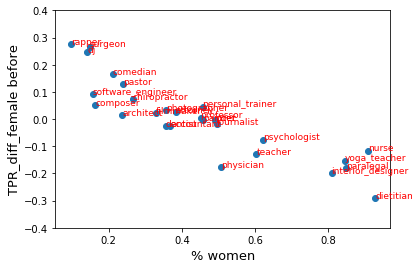

Correlation: -0.43156833757894597; p-value: 0.021840857110597522


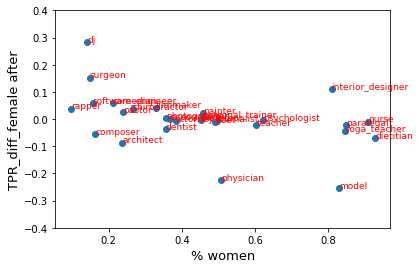

rms-diff before: 0.16231026836520052; rms-diff after: 0.0969088416990204


In [227]:


y_pred_before = clf_original.predict(X_test)
test_gender = [d["g"] for d in test]
dev_gender = [d["g"] for d in dev]
train_gender = [d["g"] for d in train]

tprs_before, tprs_change_before, mean_ratio_before = get_TPR(y_pred_before, Y_test, p2i, i2p, test_gender)
similarity_vs_tpr(tprs_change_before, word2vec, "before", "TPR", prof2fem)


#y_pred_after = clf.predict(X_test.dot(P))
y_pred_after = clf.predict(X_test.dot(P))
tprs, tprs_change_after, mean_ratio_after = get_TPR(y_pred_after, Y_test, p2i, i2p, test_gender)
similarity_vs_tpr(tprs_change_after, word2vec, "after", "TPR", prof2fem)

 
#print("TPR diff ratio before: {}; after: {}".format(mean_ratio_before, mean_ratio_after))
""" 
fprs_before, fprs_change_before, mean_ratio_before = get_FPR(y_pred_before, Y_test, p2i, i2p, test_gender)
similarity_vs_tpr(fprs_change_before, word2vec, "before", "FPR", prof2fem)


fprs, fprs_change_after, mean_ratio_after = get_FPR(y_pred_after, Y_test, p2i, i2p, test_gender)
similarity_vs_tpr(fprs_change_after, word2vec, "after", "FPR", prof2fem)

#print("TPR diff ratio before: {}; after: {}".format(mean_ratio_before, mean_ratio_after))
"""
change_vals_before = np.array(list((tprs_change_before.values())))
change_vals_after = np.array(list(tprs_change_after.values()))

print("rms-diff before: {}; rms-diff after: {}".format(rms_diff(change_vals_before), rms_diff(change_vals_after)))

In [ ]:
def tsne_by_gender(vecs, labels, title, words = None):

  tsne = TSNE(n_components=2, random_state=0)
  vecs_2d = tsne.fit_transform(vecs)
  num_labels = len(set(labels.tolist()))

  names = ["class {}".format(i) for i in range(num_labels)]
  plt.figure(figsize=(6, 5))
  colors = 'r', 'b', 'orange'
  for i, c, label in zip(set(labels.tolist()), colors, names):
    print(len(vecs_2d[labels == i, 0]))
    plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                label=label, alpha = 0.6)
  plt.legend()
  plt.title(title)
  
  if words is not None:
        k = 60
        for i in range(k):
            
            j = np.random.choice(range(len(words)))
            label = labels[i]
            w = words[j]
            x,y = vecs_2d[i]
            plt.annotate(w , (x,y), size = 10, color = "black" if label == 1 else "black")
            
  plt.show()
  return vecs_2d

In [ ]:
prof = "personal_trainer"
idx = np.random.rand(X_dev.shape[0]) < 0.1
prof_idx = Y_dev == p2i[prof]
n = 3000
tsne_by_gender(X_dev[prof_idx][:n], np.array(dev_gender)[prof_idx][:n], "tsne by gender, before, {}".format(prof))
tsne_by_gender((X_dev[prof_idx].dot(P))[:n], np.array(dev_gender)[prof_idx][:n], "tsne by gender, after. {}".format(prof))

In [ ]:
def count_profs(data_y, i2p):
    d = Counter()
    for y in data_y:
        d[i2p[y]] += 1
    return d

In [ ]:
count_profs(Y_train, i2p)

In [ ]:
count_profs(Y_dev, i2p)

In [ ]:
count_profs(Y_test, i2p)

In [ ]:
train[0]